GROUP 10

PHASE 2 CAPSTONE PROJECT

MEMBERS

Job Cheruyot

Eric Miriti

Susan Mworia

Lydia Mangoa

Evans Makau

Wambui Kariuki  

In [134]:
import pandas as pd
import ast
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_1samp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [265]:
merged_data = pd.read_csv('merged_movies.csv')
merged_data.head()

primary_title  start_year  runtime_minutes              genres  \
0   #ALLMYMOVIES        2015              NaN         Documentary   
1      #Captured        2017             81.0            Thriller   
2  #FollowFriday        2016             90.0            Thriller   
3        #Horror        2015            101.0  Crime,Drama,Horror   
4  #Lucky Number        2015             80.0              Comedy   

   vote_average  vote_count  \
0           9.0           4   
1           3.2           6   
2           3.2           7   
3           3.3         102   
4           6.0           2   

                                            Top Cast                Director  \
0                                       Shia LaBeouf             Luke Turner   
1  Lizze Gordon, Cody Renee Cameron, Eve Marlowe,...             Joe Homokay   
2  Courtney Lakin, Joseph Poliquin, Ashley Bratch...            Micho Rutare   
3  Chloë Sevigny, Timothy Hutton, Natasha Lyonne,...            Tara Subkoff   
4  Tom Pelphrey, Natalie Hall, Method Man, Malcol...  Brendan Gabriel Murphy   

   popularity     Budget Revenue  
0       0.840        0.0       0  
1       1.418        0.0       0  
2       1.646        0.0       0  
3       6.099  1500000.0       0  
4       0.919  1000000.0       0

In [236]:
merged_data.duplicated().sum()

0

In [237]:
merged_data.isna().sum()

primary_title         0
start_year            0
runtime_minutes     633
genres               97
vote_average          0
vote_count            0
Top Cast           1125
Director            368
popularity            0
Budget               95
Revenue              95
dtype: int64

In [238]:
# Fill non numerical missing values with N/A
merged_data[['Director', 'Top Cast', 'genres']] = merged_data[['Director', 'Top Cast', 'genres']].fillna("N/A")

In [239]:
merged_data.isna().sum()

primary_title        0
start_year           0
runtime_minutes    633
genres               0
vote_average         0
vote_count           0
Top Cast             0
Director             0
popularity           0
Budget              95
Revenue             95
dtype: int64

In [240]:
# Ensure columns for correlation are numeric
merged_data['Revenue'] = pd.to_numeric(merged_data['Revenue'], errors='coerce')
merged_data['popularity'] = pd.to_numeric(merged_data['popularity'], errors='coerce')
merged_data['vote_average'] = pd.to_numeric(merged_data['vote_average'], errors='coerce')

In [241]:
# Replace rows with 0 in the revenue and budget columns with null
merged_data['Revenue'] = merged_data['Revenue'].replace(0, np.nan)

In [242]:
merged_data['Budget'] = merged_data['Budget'].replace(0, np.nan)

In [243]:
merged_data.isna().sum()

primary_title          0
start_year             0
runtime_minutes      633
genres                 0
vote_average           0
vote_count             0
Top Cast               0
Director               0
popularity             0
Budget             11526
Revenue            12190
dtype: int64

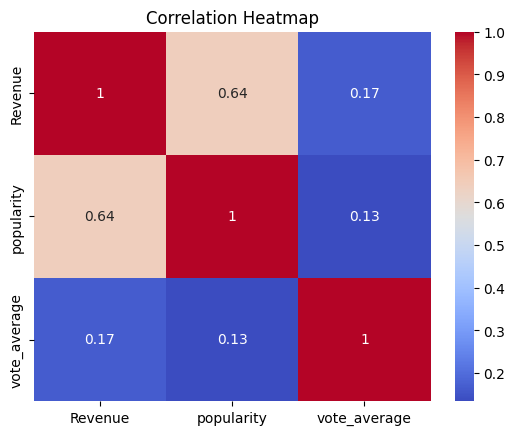

In [217]:
# Use correlation to establish the whether popularity can be used to predict revenue to fill missing values
numeric_features = merged_data[['Revenue', 'popularity', 'vote_average']]
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


As shown by the correlation matrix there is a strong positive correlation between a title's popularity and the revenue accrued (0.64). More popular movies may accrue higher revenues.

In [244]:
# Filling missing values in Revenue column based on popularity

# Ensure 'Revenue' and 'popularity' are numeric
merged_data['Revenue'] = pd.to_numeric(merged_data['Revenue'], errors='coerce')
merged_data['popularity'] = pd.to_numeric(merged_data['popularity'], errors='coerce')

# Filter non-missing data for training
non_missing = merged_data[merged_data['Revenue'].notna() & merged_data['popularity'].notna()]

# Prepare X and y for regression
X_train = non_missing[['popularity']].values  # Independent variable
y_train = non_missing['Revenue'].values  # Dependent variable

# Train-test split (optional, for model evaluation)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train_split, y_train_split)

# Predict missing Revenue values
missing = merged_data[merged_data['Revenue'].isna() & merged_data['popularity'].notna()]
X_missing = missing[['popularity']].values
predicted_revenue = regressor.predict(X_missing)

# Fill the missing Revenue values with predictions
merged_data.loc[merged_data['Revenue'].isna() & merged_data['popularity'].notna(), 'Revenue'] = predicted_revenue

merged_data.head()

primary_title  start_year  runtime_minutes              genres  \
0   #ALLMYMOVIES        2015              NaN         Documentary   
1      #Captured        2017             81.0            Thriller   
2  #FollowFriday        2016             90.0            Thriller   
3        #Horror        2015            101.0  Crime,Drama,Horror   
4  #Lucky Number        2015             80.0              Comedy   

   vote_average  vote_count  \
0           9.0           4   
1           3.2           6   
2           3.2           7   
3           3.3         102   
4           6.0           2   

                                            Top Cast                Director  \
0                                       Shia LaBeouf             Luke Turner   
1  Lizze Gordon, Cody Renee Cameron, Eve Marlowe,...             Joe Homokay   
2  Courtney Lakin, Joseph Poliquin, Ashley Bratch...            Micho Rutare   
3  Chloë Sevigny, Timothy Hutton, Natasha Lyonne,...            Tara Subkoff   
4  Tom Pelphrey, Natalie Hall, Method Man, Malcol...  Brendan Gabriel Murphy   

   popularity     Budget       Revenue  
0       0.840        NaN -7.226549e+07  
1       1.418        NaN -6.258784e+07  
2       1.646        NaN -5.877036e+07  
3       6.099  1500000.0  1.578769e+07  
4       0.919  1000000.0 -7.094276e+07

In [245]:
# Set minimum revenue to $0
merged_data['Revenue'] = merged_data['Revenue'].apply(lambda x: max(0, x))

In [246]:
merged_data.head()

primary_title  start_year  runtime_minutes              genres  \
0   #ALLMYMOVIES        2015              NaN         Documentary   
1      #Captured        2017             81.0            Thriller   
2  #FollowFriday        2016             90.0            Thriller   
3        #Horror        2015            101.0  Crime,Drama,Horror   
4  #Lucky Number        2015             80.0              Comedy   

   vote_average  vote_count  \
0           9.0           4   
1           3.2           6   
2           3.2           7   
3           3.3         102   
4           6.0           2   

                                            Top Cast                Director  \
0                                       Shia LaBeouf             Luke Turner   
1  Lizze Gordon, Cody Renee Cameron, Eve Marlowe,...             Joe Homokay   
2  Courtney Lakin, Joseph Poliquin, Ashley Bratch...            Micho Rutare   
3  Chloë Sevigny, Timothy Hutton, Natasha Lyonne,...            Tara Subkoff   
4  Tom Pelphrey, Natalie Hall, Method Man, Malcol...  Brendan Gabriel Murphy   

   popularity     Budget       Revenue  
0       0.840        NaN  0.000000e+00  
1       1.418        NaN  0.000000e+00  
2       1.646        NaN  0.000000e+00  
3       6.099  1500000.0  1.578769e+07  
4       0.919  1000000.0  0.000000e+00

Filling budget in relation to average genre budgets

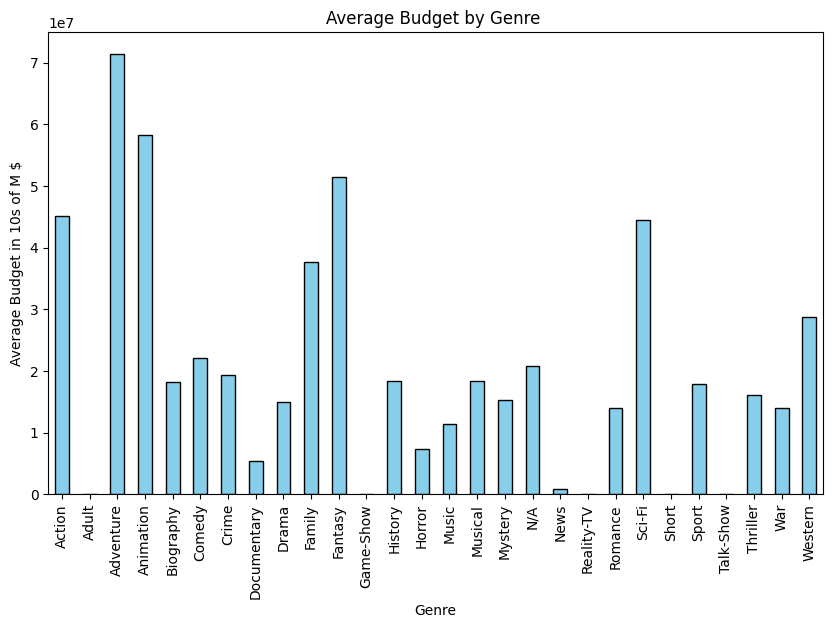

In [247]:
# Split the 'genres' column
merged_data['genres_list'] = merged_data['genres'].apply(lambda x: x.split(','))

# Explode the 'genres_list' to create one row per genre
exploded_data = merged_data.explode('genres_list')

# Group by genre and calculate the average budget for each genre
average_budget_by_genre = exploded_data.groupby('genres_list')['Budget'].mean()

# Plot the histogram of average budgets per genre
plt.figure(figsize=(10, 6))
average_budget_by_genre.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Budget by Genre ")
plt.xlabel("Genre")
plt.ylabel("Average Budget in 10s of M $")
plt.xticks(rotation=90)
plt.show()

In [248]:
# Filling budget in relation to average genre budgets
print(average_budget_by_genre)

genres_list
Action         4.518054e+07
Adult          1.000000e+05
Adventure      7.136065e+07
Animation      5.833835e+07
Biography      1.812759e+07
Comedy         2.203588e+07
Crime          1.936473e+07
Documentary    5.438894e+06
Drama          1.493286e+07
Family         3.759392e+07
Fantasy        5.138186e+07
Game-Show               NaN
History        1.836532e+07
Horror         7.279750e+06
Music          1.138641e+07
Musical        1.830451e+07
Mystery        1.532842e+07
N/A            2.072649e+07
News           8.843300e+05
Reality-TV     1.000000e+02
Romance        1.399086e+07
Sci-Fi         4.449752e+07
Short                   NaN
Sport          1.792540e+07
Talk-Show               NaN
Thriller       1.606680e+07
War            1.401433e+07
Western        2.869241e+07
Name: Budget, dtype: float64


In [251]:
# Expand the genres into separate rows
expanded_genres = merged_data.assign(Genre=merged_data['genres'].str.split(',')).explode('genres')

# Calculate the average budget for each genre
genre_avg_budget = expanded_genres.groupby('genres')['Budget'].mean()

# Fill missing budget values
def fill_runtime(row):
    if pd.isna(row['Budget']):
        genres = row['genres'].split(',')
        genre_budget = [genre_avg_budget[genre] for genre in genres if genre in genre_avg_budget]
        # Calculate the mean of the available budget
        return np.mean(genre_budget) if genre_budget else np.nan
    else:
        return row['Budget']

merged_data['Budget'] = merged_data.apply(fill_runtime, axis=1)

In [252]:
merged_data['Budget'].isna().sum()

5

In [254]:
merged_data = merged_data.dropna(subset = ['Budget'])

In [255]:
merged_data.isna().sum()

primary_title        0
start_year           0
runtime_minutes    632
genres               0
vote_average         0
vote_count           0
Top Cast             0
Director             0
popularity           0
Budget               0
Revenue              0
genres_list          0
dtype: int64

Filling runtime based on genre

In [256]:
# Expand the genres into separate rows
expanded_genres = merged_data.assign(Genre=merged_data['genres'].str.split(',')).explode('genres')

# Calculate the average runtime for each genre
genre_avg_runtime = expanded_genres.groupby('genres')['runtime_minutes'].mean()

# Fill missing runtime values
def fill_runtime(row):
    if pd.isna(row['runtime_minutes']):
        genres = row['genres'].split(',')
        genre_runtimes = [genre_avg_runtime[genre] for genre in genres if genre in genre_avg_runtime]
        # Calculate the mean of the available runtimes
        return np.mean(genre_runtimes) if genre_runtimes else np.nan
    else:
        return row['runtime_minutes']

merged_data['runtime_minutes'] = merged_data.apply(fill_runtime, axis=1)

In [257]:
merged_data.isna().sum()

primary_title      0
start_year         0
runtime_minutes    0
genres             0
vote_average       0
vote_count         0
Top Cast           0
Director           0
popularity         0
Budget             0
Revenue            0
genres_list        0
dtype: int64

In [260]:
merged_data.describe()

start_year  runtime_minutes  vote_average    vote_count  \
count  15364.000000     15364.000000  15364.000000  15364.000000   
mean    2014.183871        93.279382      5.796596    262.526686   
std        2.527871        24.651419      1.764980   1127.153963   
min     2010.000000         1.000000      0.000000      1.000000   
25%     2012.000000        84.000000      5.000000      2.000000   
50%     2014.000000        91.000000      6.000000      7.000000   
75%     2016.000000       101.000000      6.900000     48.000000   
max     2021.000000      1834.000000     10.000000  22186.000000   

         popularity        Budget       Revenue  
count  15364.000000  1.536400e+04  1.536400e+04  
mean       3.736069  1.030686e+07  1.972235e+07  
std        4.894647  2.126278e+07  9.106029e+07  
min        0.600000  1.000000e+00  0.000000e+00  
25%        0.655750  4.936315e+06  0.000000e+00  
50%        1.688000  6.574482e+06  0.000000e+00  
75%        5.436250  8.198899e+06  5.513828e+05  
max       80.773000  3.790000e+08  2.923706e+09

In [261]:
merged_data.shape

(15364, 12)

In [262]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15364 entries, 0 to 15368
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    15364 non-null  object 
 1   start_year       15364 non-null  int64  
 2   runtime_minutes  15364 non-null  float64
 3   genres           15364 non-null  object 
 4   vote_average     15364 non-null  float64
 5   vote_count       15364 non-null  int64  
 6   Top Cast         15364 non-null  object 
 7   Director         15364 non-null  object 
 8   popularity       15364 non-null  float64
 9   Budget           15364 non-null  float64
 10  Revenue          15364 non-null  float64
 11  genres_list      15364 non-null  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 1.5+ MB


### **DATA VISUALIZATION**

#### Distribution of Budget, Revenue, and Runtime

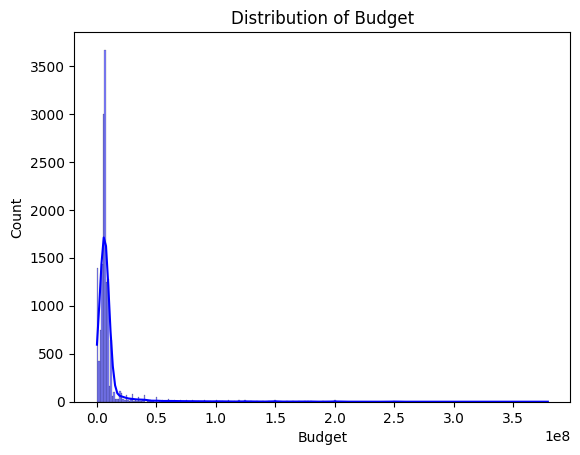

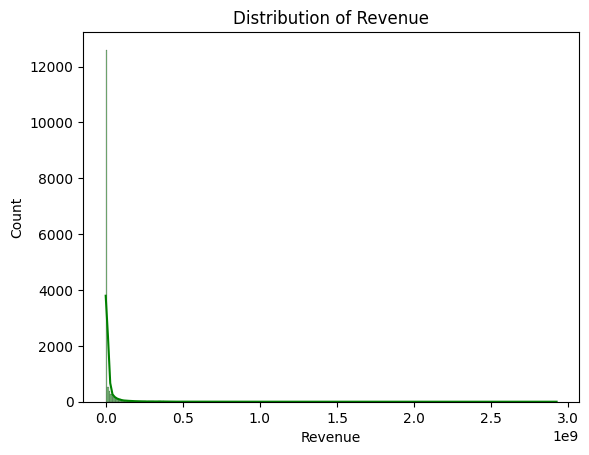

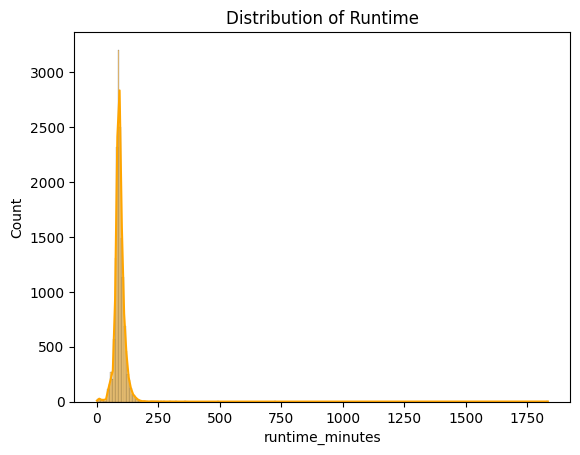

In [107]:
# Distribution of Budget, Revenue, and Runtime
sns.histplot(merged_data['Budget'], bins=300, kde=True, color='blue').set(title='Distribution of Budget')
plt.show()
sns.histplot(merged_data['Revenue'], bins=300, kde=True, color='green').set(title='Distribution of Revenue')
plt.show()
sns.histplot(merged_data['runtime_minutes'], bins=300, kde=True, color='orange').set(title='Distribution of Runtime')
plt.show()

These plots show how budget, revenue, and runtime are distributed, helping us understand patterns in successful movies. By analyzing these trends, we can identify how much to spend, what revenue to aim for, and the ideal runtime for films that resonate with audiences. This data will guide decisions for creating box office hits for our new movie studio.

#### Average Budget vs Revenue by Genre

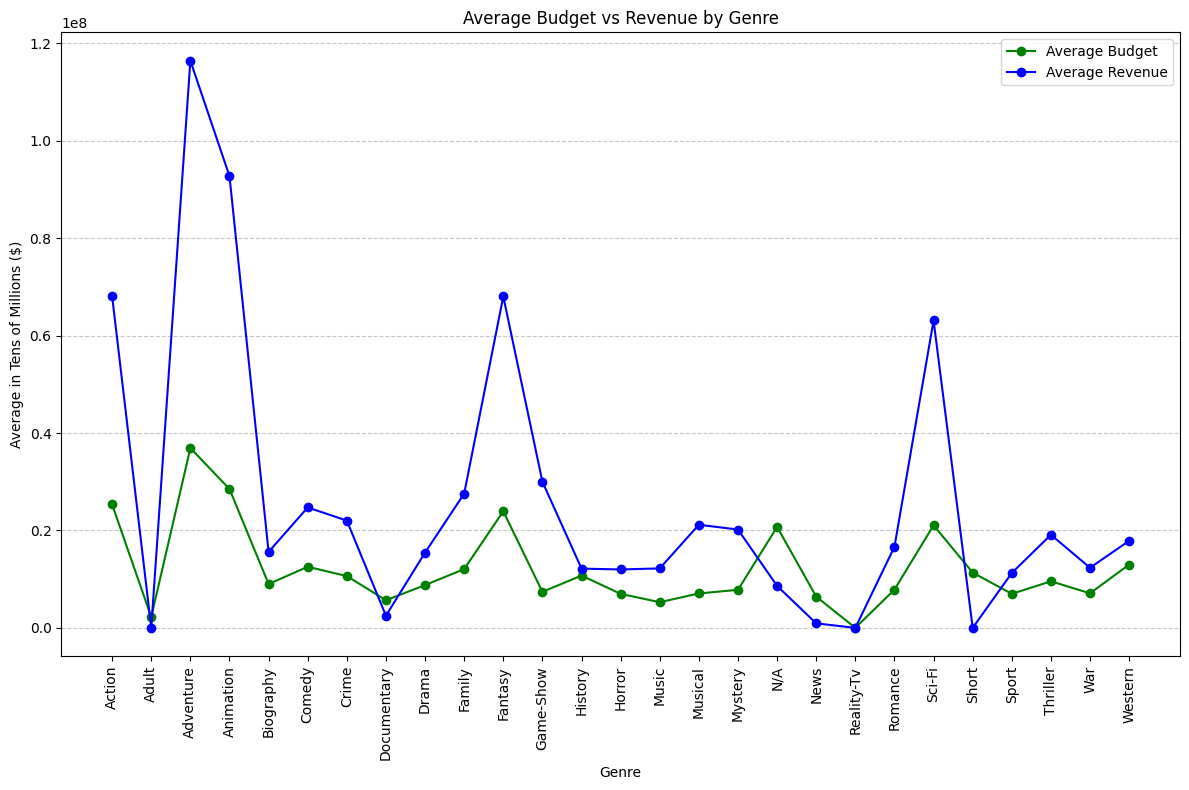

In [170]:
# Group by genre and calculate the average budget and revenue for each genre
average_budget_revenue_by_genre = exploded_data.groupby('genres_list')[['Budget', 'Revenue']].mean()

# Line plot
plt.figure(figsize=(12, 8))
plt.plot(average_budget_revenue_by_genre.index, average_budget_revenue_by_genre['Budget'], marker='o', label='Average Budget', color='green')
plt.plot(average_budget_revenue_by_genre.index, average_budget_revenue_by_genre['Revenue'], marker='o', label='Average Revenue', color='blue')

plt.title("Average Budget vs Revenue by Genre")
plt.xlabel("Genre")
plt.ylabel("Average in Tens of Millions ($)")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

DATA STATISTICS

Below are the data statistics concepts we will delve into:



1.   Probability Mass Function (PMF)
2.   Probability Density Function (PDF)


### Probability Mass Function (PMF)

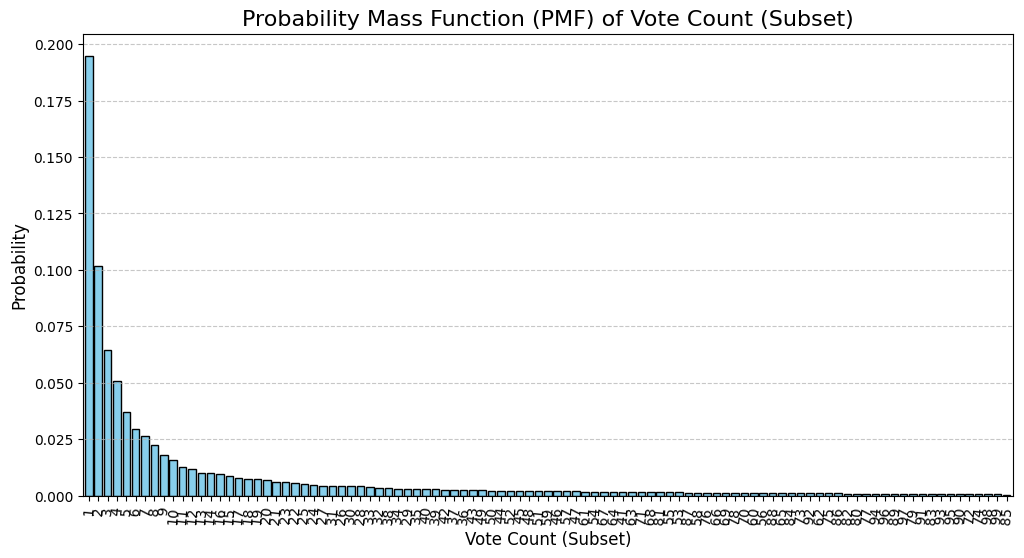

In [112]:
# Compute PMF for 'vote_count'
pmf_vote_count = merged_data['vote_count'].value_counts(normalize=True)

# Focus on a subset of 'vote_count' values for clarity
subset_vote_count = pmf_vote_count[pmf_vote_count.index < 100]

# Plot the PMF for the subset
plt.figure(figsize=(12, 6))
subset_vote_count.plot(kind='bar', color='skyblue', width=0.8, edgecolor='black')

plt.title('Probability Mass Function (PMF) of Vote Count (Subset)', fontsize=16)
plt.xlabel('Vote Count (Subset)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(fontsize=10, rotation=85)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The PMF plot for vote_count shows that most values are concentrated at lower counts, with probabilities rapidly decreasing for higher values. This suggests a distribution skewed toward smaller vote counts, consistent with a Poisson distribution where the majority of observations are near the mean. This visualization highlights the rarity of higher vote counts relative to the dataset's size.

### Probability Density Function (PDF

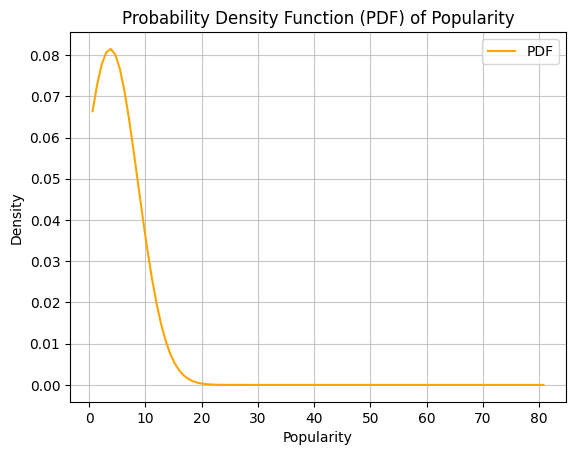

In [125]:
# Probability Density Function (PDF) for popularity
# Purpose: To visualize the likelihood of different values of a continuous variable (popularity)
popularity = merged_data['popularity']
pdf_x = np.linspace(popularity.min(), popularity.max(), 100)
pdf_y = norm.pdf(pdf_x, np.mean(popularity), np.std(popularity))

plt.figure()
plt.plot(pdf_x, pdf_y, label='PDF', color='orange')
plt.title('Probability Density Function (PDF) of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

The Probability Density Function (PDF) of popularity shows a right-skewed normal distribution with the highest density around the mean. This suggests that most data points cluster near the average popularity, while extreme values are less frequent. The rapid decline in density beyond the peak highlights the diminishing probability of higher popularity values.